<a href="https://colab.research.google.com/github/Gypsy247/Self-Driving-Car-using-OpenCV/blob/main/behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Gypsy247/Self-Driving-Car-using-OpenCV

Cloning into 'Self-Driving-Car-using-OpenCV'...
remote: Enumerating objects: 29138, done.
remote: Total 29138 (delta 0), reused 0 (delta 0), pack-reused 29138
Receiving objects: 100% (29138/29138), 377.30 MiB | 13.44 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (10650/10650), done.


In [2]:
!dir Self-Driving-Car-using-OpenCV

behavioral_cloning.ipynb      model.h5
binary_deep_neural_net.ipynb  multi_deep_neural_net.ipynb
drive.py		      perceptron.ipynb
driving_log.csv		      polynomial_regression.ipynb
IMG			      README.md
lane_identifier.py	      requirements.txt
logistic_regression.ipynb


In [3]:
!pip3 install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [5]:
datadir = 'Self-Driving-Car-using-OpenCV'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
# since the file names in the columns were overflowing
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


center  \
0  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_107.jpg   
1  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_208.jpg   
2  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_314.jpg   
3  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_417.jpg   
4  C:\Users\sarma\Desktop\Data\IMG\center_2018_11_28_23_31_48_523.jpg   

                                                                left  \
0   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_107.jpg   
1   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_208.jpg   
2   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_314.jpg   
3   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_417.jpg   
4   C:\Users\sarma\Desktop\Data\IMG\left_2018_11_28_23_31_48_523.jpg   

                                                                right  \
0   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_107.jpg   
1   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_208.jpg   
2   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_314.jpg   
3   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_417.jpg   
4   C:\Users\sarma\Desktop\Data\IMG\right_2018_11_28_23_31_48_523.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000082  
1  0.0       0.0       0.0      0.000082  
2  0.0       0.0       0.0      0.000082  
3  0.0       0.0       0.0      0.000082  
4  0.0       0.0       0.0      0.000082

In [6]:
def path_leaf(path):
  # accessing the tailend of the paths i.e. the path of our images
  head, tail = ntpath.split(path)
  return tail

# invoking the path function to get the images corresponding to each camera and storing them in the respective databases
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_11_28_23_31_48_107.jpg  left_2018_11_28_23_31_48_107.jpg   
1  center_2018_11_28_23_31_48_208.jpg  left_2018_11_28_23_31_48_208.jpg   
2  center_2018_11_28_23_31_48_314.jpg  left_2018_11_28_23_31_48_314.jpg   
3  center_2018_11_28_23_31_48_417.jpg  left_2018_11_28_23_31_48_417.jpg   
4  center_2018_11_28_23_31_48_523.jpg  left_2018_11_28_23_31_48_523.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_11_28_23_31_48_107.jpg  0.0       0.0       0.0      0.000082  
1  right_2018_11_28_23_31_48_208.jpg  0.0       0.0       0.0      0.000082  
2  right_2018_11_28_23_31_48_314.jpg  0.0       0.0       0.0      0.000082  
3  right_2018_11_28_23_31_48_417.jpg  0.0       0.0       0.0      0.000082  
4  right_2018_11_28_23_31_48_523.jpg  0.0       0.0       0.0      0.000082

Visualizing the frequency of steering angles using a histogram to see any biases that may be present.  
Trimming the data so we can reduce the bias towards an angle of zero degrees





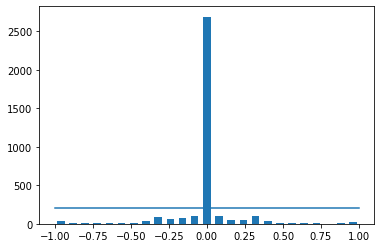

In [7]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
# We center our values around zero.
# Since this would add adjacent values and produce essentially the double of the values we see, we multiply the whole expression by 0.5 
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 3546
removed: 2489
remaining: 1057


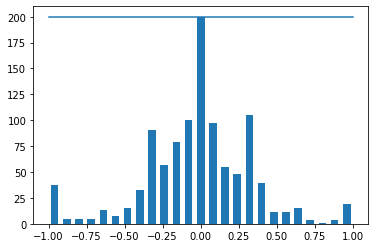

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_11_28_23_31_49_149.jpg
left        left_2018_11_28_23_31_49_149.jpg  
right       right_2018_11_28_23_31_49_149.jpg 
steering    0.0                               
throttle    0.022093                          
reverse     0.0                               
speed       0.036961                          
Name: 10, dtype: object


Creating the Training and Validation sets by splitting our data

Training Samples: 845
Valid Samples: 212


Text(0.5, 1.0, 'Validation set')

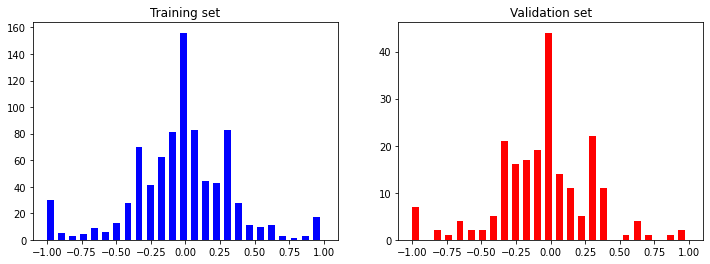

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')

Function to zoom into the image for Data Augmentation

In [11]:
def zoom(image):
  zoom = iaa.Affine(scale = (1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

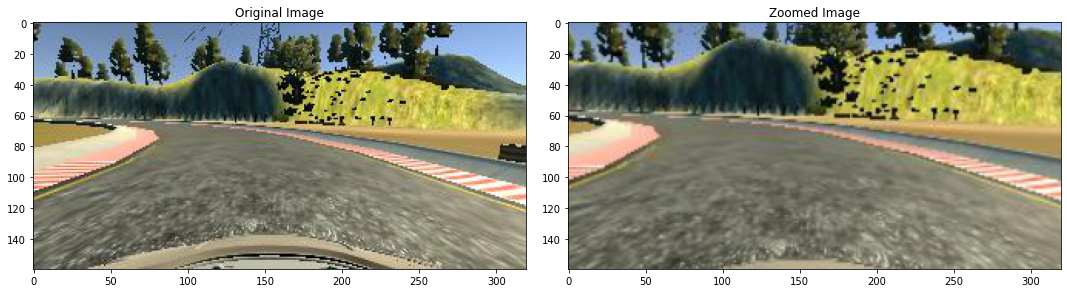

In [12]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Function for panning around the image for Data Augmentation

In [13]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

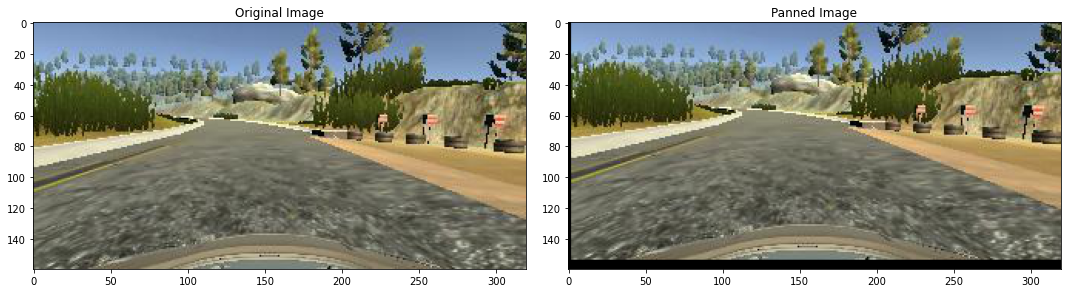

In [14]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Function for adjusting the brightness of the image for Data Augmentation

In [15]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

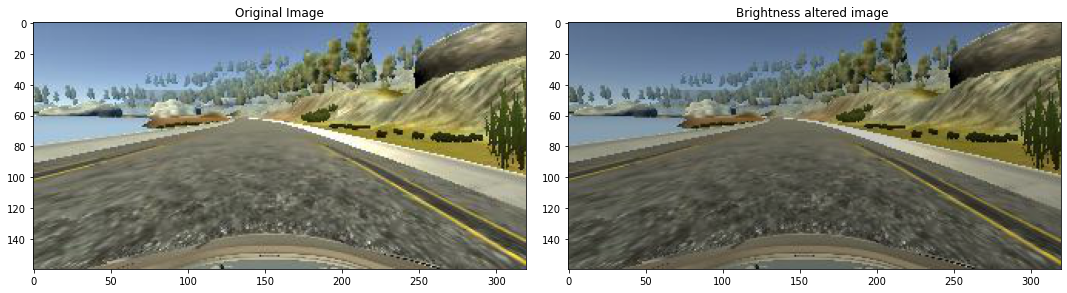

In [16]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Function to flip the image along with the respective steering angle for Data Augmentation

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.4185579')

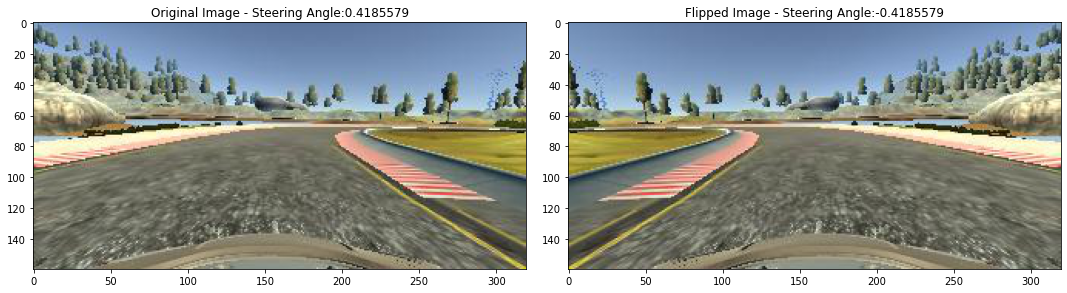

In [17]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

Function that adjusts the propability of applying a specific augmentation technique to an image to 50%

In [18]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

Comparing the original images with the augmented versions

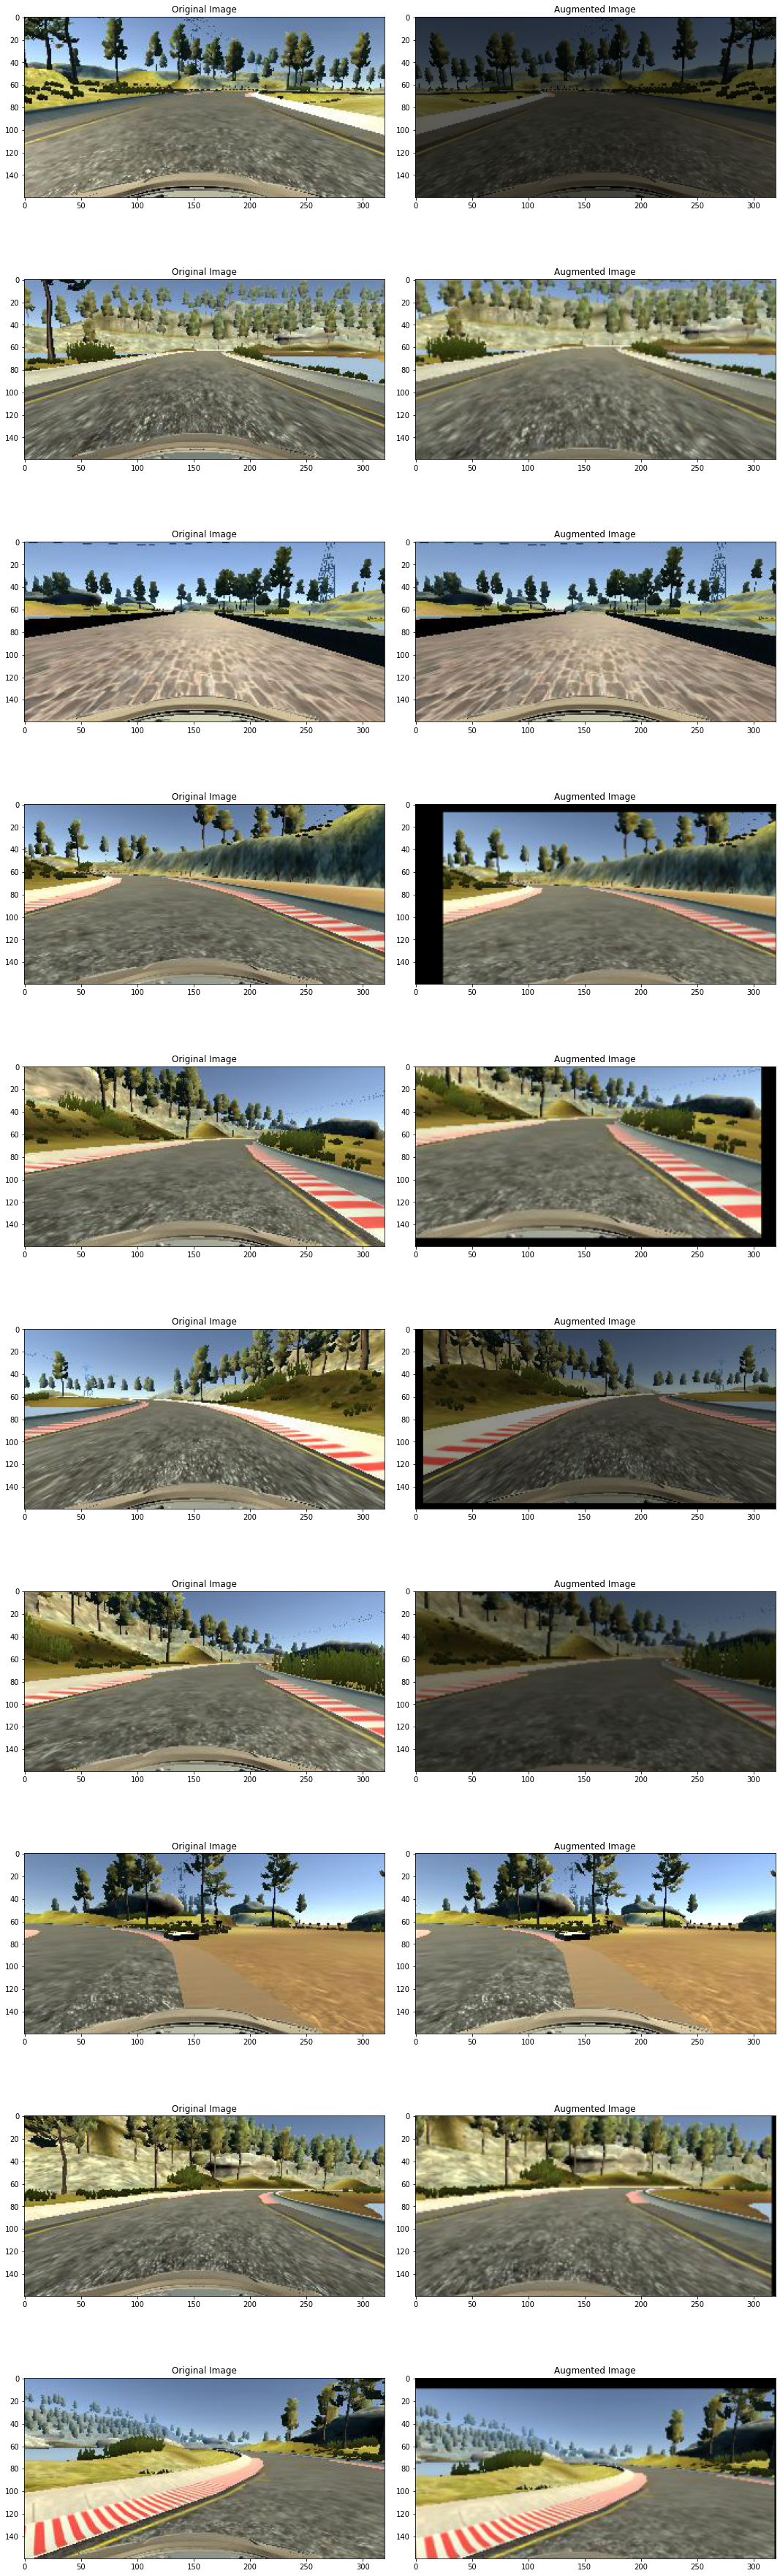

In [19]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize = (15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Pre-processing the images

In [20]:
def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

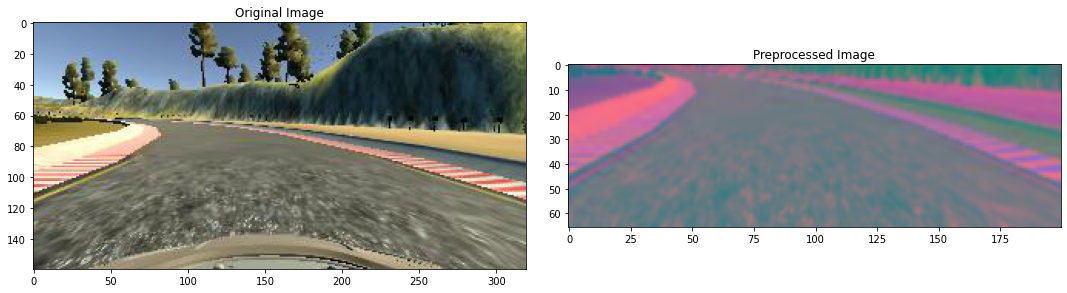

In [21]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Generating the augmented data by defining an image generator

In [22]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

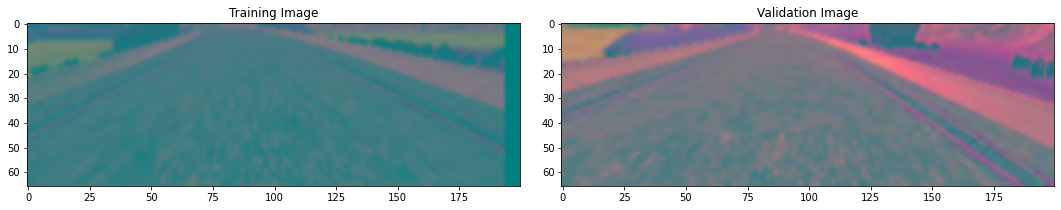

In [23]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [24]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size = (5,5), strides = (2,2), input_shape = (66,200,3), activation = 'elu'))
  model.add(Convolution2D(36, kernel_size = (5,5), strides = (2,2), activation = 'elu'))
  model.add(Convolution2D(48, kernel_size = (5,5), strides = (2,2), activation = 'elu'))
  model.add(Convolution2D(64, kernel_size = (3,3), activation = 'elu'))
  model.add(Convolution2D(64, kernel_size = (3,3), activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation ='elu'))
  model.add(Dense(1))
  
  optimizer= Adam(lr = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)

  return model

In [25]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch = 300, 
                                  epochs = 10,
                                  validation_data = batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps = 200,
                                  verbose = 1,
                                  shuffle = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


None
Epoch 1/10
300/300 [==============================] - 222s 691ms/step - loss: 0.1353 - val_loss: 0.0793
Epoch 2/10
300/300 [==============================] - 200s 668ms/step - loss: 0.0992 - val_loss: 0.0684
Epoch 3/10
300/300 [==============================] - 200s 670ms/step - loss: 0.0842 - val_loss: 0.0701
Epoch 4/10
300/300 [==============================] - 201s 674ms/step - loss: 0.0815 - val_loss: 0.0717
Epoch 5/10
300/300 [==============================] - 205s 686ms/step - loss: 0.0807 - val_loss: 0.0649
Epoch 6/10
300/300 [==============================] - 205s 685ms/step - loss: 0.0757 - val_loss: 0.0547
Epoch 7/10
300/300 [==============================] - 203s 678ms/step - loss: 0.0744 - val_loss: 0.0577
Epoch 8/10
300/300 [==============================] - 202s 675ms/step - loss: 0.0723 - val_loss: 0.0633
Epoch 9/10
300/300 [==============================] - 202s 675ms/step - loss: 0.0715 - val_loss: 0.0664
Epoch 10/10
300/300 [==============================] - 202s

Text(0.5, 0, 'Epoch')

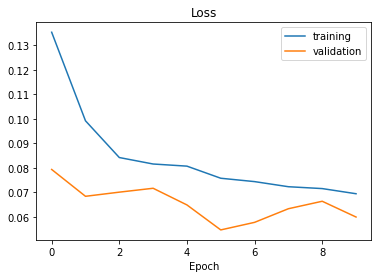

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [27]:
model.save('model.h5')

In [28]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>